In [2]:
import pandas as pd
import numpy as np
from collections import Counter                         #eda
import matplotlib.pyplot as plt                         #plotting
from sklearn.model_selection import train_test_split, KFold    # model data train/test split
from sklearn.preprocessing import StandardScaler, LabelEncoder  #scaling the sizing, encode the names
from sklearn.pipeline import Pipeline   #for pipeline schedule 
import torch                        #for tensoring the data
from torch.utils.data import SubsetRandomSampler, DataLoader, TensorDataset
#sampling kfolds
import torch.nn as nn               #for model classes
import torch.nn.functional as F     #for activation function
import tqdm                         #progress bar for training

In [3]:
iris = pd.read_csv('https://raw.githubusercontent.com/pandas-dev/pandas/main/pandas/tests/io/data/csv/iris.csv')
iris.head(2)
iris.iloc[50:75]


,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
50,7.0,3.2,4.7,1.4,Iris-versicolor
51,6.4,3.2,4.5,1.5,Iris-versicolor
52,6.9,3.1,4.9,1.5,Iris-versicolor
53,5.5,2.3,4.0,1.3,Iris-versicolor
54,6.5,2.8,4.6,1.5,Iris-versicolor
55,5.7,2.8,4.5,1.3,Iris-versicolor
56,6.3,3.3,4.7,1.6,Iris-versicolor
57,4.9,2.4,3.3,1.0,Iris-versicolor
58,6.6,2.9,4.6,1.3,Iris-versicolor
59,5.2,2.7,3.9,1.4,Iris-versicolor


In [4]:
# looking at the range shapes of the data
iris.columns
iris.info

<bound method DataFrame.info of      SepalLength  SepalWidth  PetalLength  PetalWidth            Name
0            5.1         3.5          1.4         0.2     Iris-setosa
1            4.9         3.0          1.4         0.2     Iris-setosa
2            4.7         3.2          1.3         0.2     Iris-setosa
3            4.6         3.1          1.5         0.2     Iris-setosa
4            5.0         3.6          1.4         0.2     Iris-setosa
..           ...         ...          ...         ...             ...
145          6.7         3.0          5.2         2.3  Iris-virginica
146          6.3         2.5          5.0         1.9  Iris-virginica
147          6.5         3.0          5.2         2.0  Iris-virginica
148          6.2         3.4          5.4         2.3  Iris-virginica
149          5.9         3.0          5.1         1.8  Iris-virginica

[150 rows x 5 columns]>

In [5]:
#checking for missing values - no missing value
iris[iris.isna().any(axis=1)]

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name


Text(0, 0.5, 'Petal length')

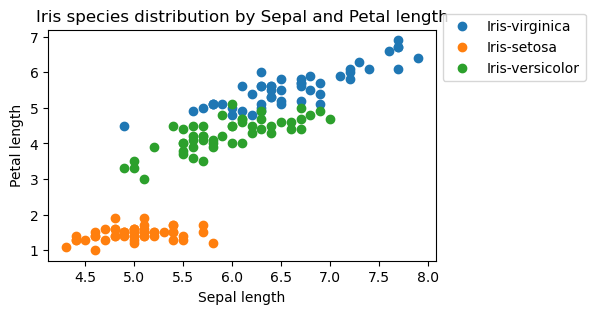

In [6]:
# dist. of species by petal and sepal length - 

plt.figure(figsize= (5,3))
plt.scatter(x= iris.SepalLength.loc[iris['Name'] == 'Iris-virginica'] , y= iris.PetalLength.loc[iris['Name'] == 'Iris-virginica'] , label= 'Iris-virginica')
plt.scatter(x= iris.SepalLength.loc[iris['Name'] == 'Iris-setosa'] , y= iris.PetalLength.loc[iris['Name'] == 'Iris-setosa'] , label= 'Iris-setosa')
plt.scatter(x= iris.SepalLength.loc[iris['Name'] == 'Iris-versicolor'] , y= iris.PetalLength.loc[iris['Name'] == 'Iris-versicolor'] , label= 'Iris-versicolor')
plt.title('Iris species distribution by Sepal and Petal length')
plt.legend(loc= (2),bbox_to_anchor= (1,1.1))
plt.xlabel('Sepal length')
plt.ylabel('Petal length')


<AxesSubplot:ylabel='Frequency'>

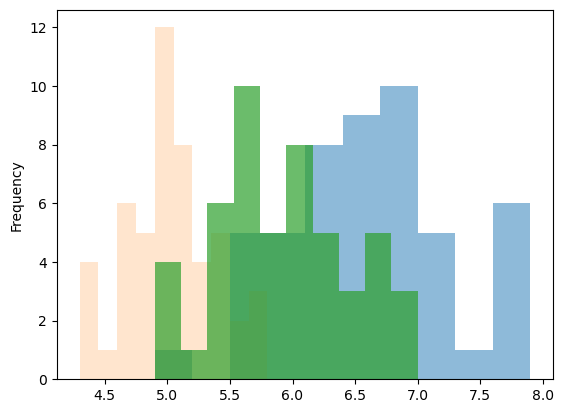

In [7]:
#the distribution of the species with reg. to the sepal length
iris['SepalLength'].loc[iris['Name'] == 'Iris-virginica'].plot.hist(alpha= 0.5)
iris['SepalLength'].loc[iris['Name'] == 'Iris-setosa'].plot.hist(alpha= 0.2)
iris['SepalLength'].loc[iris['Name'] == 'Iris-versicolor'].plot.hist(alpha= 0.7)

the data is balanced. 

In [8]:
#making sure the data is balanced:
for type in iris['Name'].unique():
    current_iris = iris.loc[iris['Name']==type].count()
    print(type, ': ', current_iris[4])


Iris-setosa :  50
Iris-versicolor :  50
Iris-virginica :  50


In [9]:
#split the data into train and test, 20% test size 
# iris.drop('Name', axis=1).values - output is an np array - I want to keep it i.o to use head().
X_train, X_test, y_train, y_test = train_test_split(iris.drop('Name', axis=1), iris['Name'].values, test_size= 0.2, random_state= 42)
X_train.head(2)

,SepalLength,SepalWidth,PetalLength,PetalWidth
22,4.6,3.6,1.0,0.2
15,5.7,4.4,1.5,0.4


In [10]:
#label encoding for the iris names: find unique values
#iris['Name'].unique()
le = LabelEncoder()
le.fit(y_train)
le.classes_
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [11]:
# manual labeling: set values 0-2 to names:
#iris['Name'] = iris['Name'].map({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})

In [12]:
#scale to values between zero and one. I am using pipeline although there is only one step
#could I use the label encoder also in the pipeline without affecting X values?

pipe = Pipeline([(
    'scaler', StandardScaler(),
    )
])

In [13]:
#fit pipeline to data
fitted_X_train = pipe.fit(X_train).transform(X_train)

fitted_X_test = pipe.transform(X_test)

In [14]:
# convert the data into tensors:

X_train = torch.FloatTensor(fitted_X_train)
X_test = torch.FloatTensor(fitted_X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

Defining the ANN model: 
    architecture: fully connected network
    Input layer - input dimentions(4), out- 50 (Layer1)
    Fully connected layer - 50 nodes (Layer2)
    Fully connected layer - 50 nodes (Layer3)
    Output layer - 3 output classess (Layer3)
    ReLU activation function 
    softmax at the output for training, Argmax for test 
    Loss: Cross Entropy - the probability of each prediction given each observation
    learning rate for optimiser - 0.01

In [15]:
#architecture - building the layers:

class ANN_Model(nn.Module):
    def __init__(self, input_dim):
        super(ANN_Model, self).__init__()
        self.Layer1 = nn.Linear(input_dim, 50)
        self.Layer2 = nn.Linear(50, 50)
        self.Layer3 = nn.Linear(50, 50)
        self.Layer4 = nn.Linear(50, 3)
        
        self.output = nn.Linear(in_features= 12, out_features= 3)


#loss function with relu and soft max    
    def forward(self, x):
        x = F.relu(self.Layer1(x))
        x = F.relu(self.Layer2(x))
        x = F.relu(self.Layer3(x))
        x = F.softmax(self.Layer4(x), dim= 1)
     
        return x

In [16]:
# a func for resetting the weights between the cross validation folds, to avoid weight leakage
def reset_weights(m):       #m will be the model
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            #print(f'Reset trainable parameters of layer {layer}')
            layer.reset_parameters()

setting the grounds: epochs, cross validation, loss recording

In [17]:
# setting epochs and collecting results of the loss in a list. 
# since the dataset is small, set cross validation to avoid overfitting. 
# each fold should be >=30. There are 120 samples, therefore 4 folds  
epochs = 70
folds_nr = 4        
folds = KFold(n_splits= folds_nr, shuffle= True, random_state= 42)  #random state fixes the randomized values to the same seed each time
loss_function = nn.CrossEntropyLoss()


In [18]:
#function for plotting the loss/accuracy for each epoch
def acc_loss_plot(fold, accuracy_list, loss_list):
    fig, (a1, a2) = plt.subplots(2, figsize= (8,3), sharex= True)
    a1.plot(loss_list)
    a1.set_ylabel('loss')
    a2.plot(accuracy_list)
    a2.set_ylabel('accuracy')
    a2.set_xlabel('epochs')
    a1.set_title(f'loss for fold {fold}')
    a2.set_title(f'accuracy for fold {fold}')
    plt.show()
    
    return a1, a2

In [19]:
#dict for the results of the folds
folds_results = []
torch.manual_seed(42)

for early stopping - when the accuracy approaches one - stop the epochs

Fold: 0


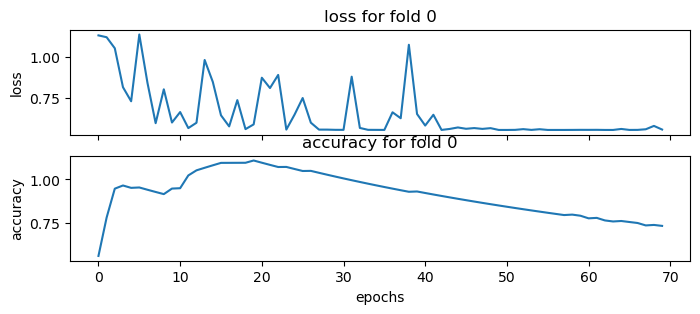

average training loss for fold 0:  0.6542229507650648
accuracy for fold 0 is 90.00%

Fold: 1


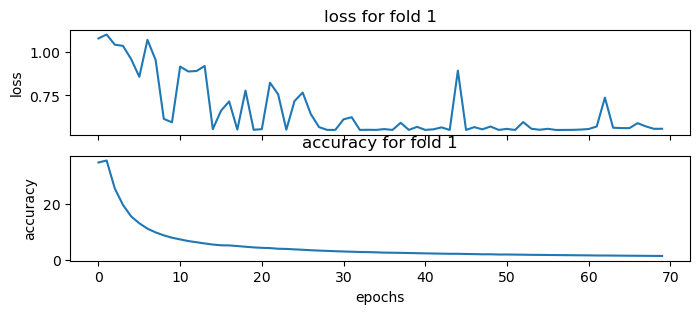

average training loss for fold 1:  0.6611791832106454
accuracy for fold 1 is 96.67%

saving model for fold 1
Fold: 2


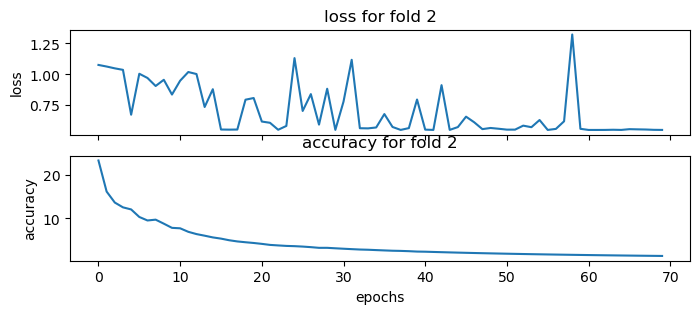

average training loss for fold 2:  0.706216197354453
accuracy for fold 2 is 93.33%

Fold: 3


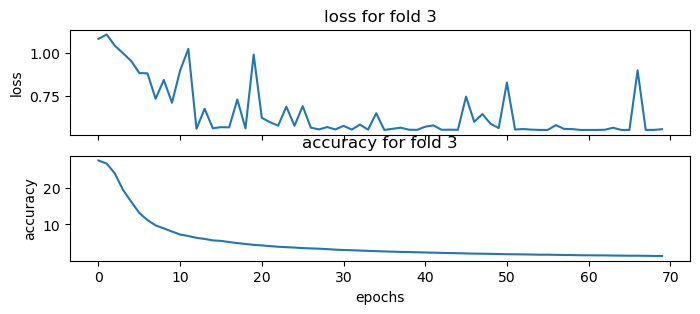

average training loss for fold 3:  0.6528531210763114
accuracy for fold 3 is 96.67%



In [44]:
#model training
#iterate over the folds, 

for fold, (train_ids,val_ids) in enumerate(folds.split(X_train)):
    
    #lists for the results of the epochs
    train_loss_list = []
    train_accuracy_list = []

    dataset = TensorDataset(X_train, y_train)   #need to combine the data to apply the Kfold on all data 
     
    # printing fold indicator
    print(f'Fold: {fold}')
    
    # setting the splits of validation samples -- make the split then load
    train_sampler = SubsetRandomSampler(train_ids)
    val_sampler =  SubsetRandomSampler(val_ids)
    
    train_loader = DataLoader(dataset, sampler= train_sampler)
    val_loader = DataLoader(dataset, sampler= val_sampler)
    
    
    # initialize optimizer with the model class
    iris_model = ANN_Model(4)
    iris_model.apply(reset_weights)
    
    
    optimizer = torch.optim.Adam(iris_model.parameters(), lr=0.0001)

    # iterating training over epochs
    for epoch in range(epochs):       #tdqm.trange(epochs) gives here a cool progress bar
        
        #initialize loss and accuracy
        loss = _
        corr = 0
        #iterate over the training data (no batches bcz the dataset is small):
        for i, data in enumerate(train_loader, 0):
            
            inputs, targets = data
            optimizer.zero_grad()       #optimizer at zero gradients
            
            # outputs are the predictions of the model
            outputs = iris_model(inputs)

            # calculate loss - prediction vs the targets y
            loss = loss_function(outputs, targets)  
                        
            # calculate accuracy
            _, predicted = outputs.max(1)       # maximum value of all elements in the input tensor.

            total += targets.size(0)
            
            corr += predicted.eq(targets).sum().item()      # Computes element-wise equality


            loss.backward()             #back propagation for weights and biases
            optimizer.step()            #perform optimization
            
        #calculating running loss: in the loss function (cross entropy) the loss is 
        current_loss = loss.item()         
        
        #collect the loss for each epoch
        train_loss_list.append(current_loss)
        
                # calculating and collecting accuracy
        correct_pred = 100 * corr / total
        train_accuracy_list.append(correct_pred)
    
    #print losses by epoch:
    #print([f'loss for epoch {i} is {l:.4f}\n' for i, l in enumerate(loss_list)])
    
    #plot loss development:
    acc_loss_plot(fold, train_accuracy_list, train_loss_list)
    
    # averageg loss
    avg_loss = np.average(train_loss_list)
    print(f'average training loss for fold {fold}: ', avg_loss)
      
        
    # model evaluation on the valuation data: 
    correct, total = 0, 0
    with torch.no_grad():    #use no grad for the testing - no backwards calculations - more efficient            
        
        #iteration over the validation data - just like in the training
        for i, data in enumerate(val_loader):
            
            inputs, targets = data
            outputs = iris_model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)   # 1 bool for keep dimentions == true
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
    #review the results
    
    print(f'accuracy for fold {fold} is {(correct / total * 100):.2f}%\n')
    
    
    #save the fold if better than the previous: 
    
    val_accuracy = correct / total
    print
    if fold == 0:
        folds_results.append(val_accuracy)   
    
    elif val_accuracy > folds_results[fold]:
        folds_results.append(val_accuracy)
        
        print(f'saving model for fold {fold}')
        save_path = f'./model_fold{fold}.pth'
        torch.save(iris_model.state_dict(), save_path)   #state.dict() maps each layer to its parameter tensor.
    
    # need to delete all other models that are not the best. 
    
    folds_results.append(val_accuracy)



next steps: 
1. validation loss
2. early stopping 
3. plot validation accuracy and loss
4. test